In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [96]:
data_path = './data/images/pet_split/'
train_path = os.path.join(data_path,'train')
val_path = os.path.join(data_path,'val')
test_path = os.path.join(data_path,'test')

In [97]:
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

In [ ]:
#datasets

In [98]:
train_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 5153 files belonging to 2 classes.


In [99]:
validation_dataset = image_dataset_from_directory(val_path,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 643 files belonging to 2 classes.


In [100]:
test_dataset = image_dataset_from_directory(test_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 647 files belonging to 2 classes.


In [101]:
class_names = train_dataset.class_names
print(class_names)

['clear', 'mixed']


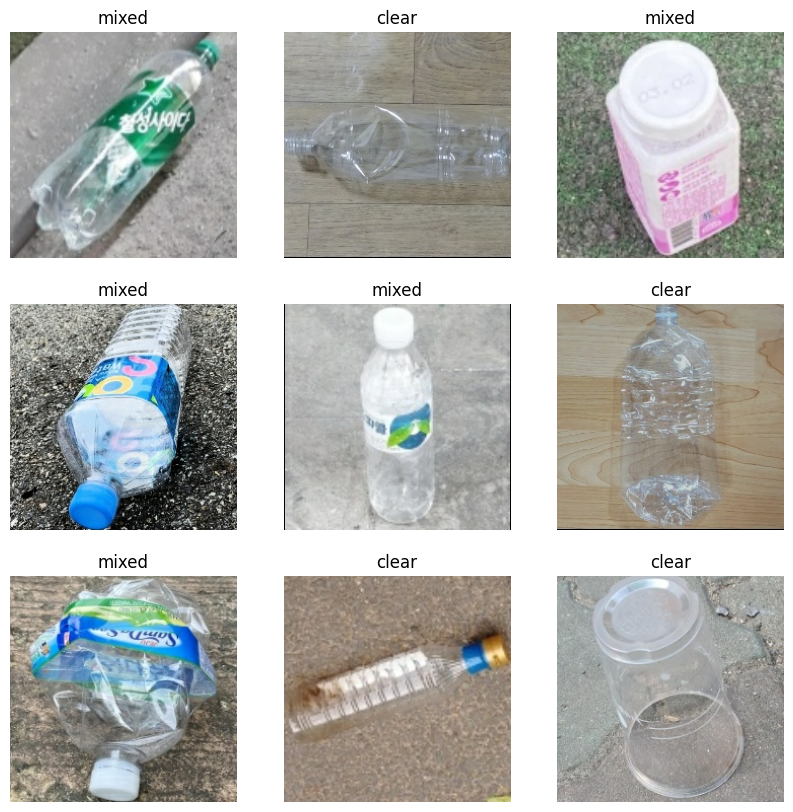

In [102]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [103]:
#aug layers

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# apply aug to train dataset

In [104]:
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [105]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [106]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [107]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [108]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 7, 7, 960)


In [109]:
#freeze base model
base_model.trainable = False

In [110]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [111]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 960)


In [112]:
prediction_layer = tf.keras.layers.Dense(2,activation = 'softmax')

In [113]:
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 2)


In [114]:
# model layers

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [115]:
# model compile

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [1]:
initial_epochs = 100

In [117]:
#set callback

cb_es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',            
                   mode='auto',                        
                   verbose=1,                           
                   patience=5)                          

checkpoint_path = "./runs/mnet_mix/{epoch:02d}-{val_accuracy:.5f}.h5"

cb_cp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=False,
    save_weights_only=False, mode='auto', save_freq='epoch', options=None,
)

In [118]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks=[cb_es,cb_cp],
                    validation_data=validation_dataset)

Epoch 1/100
40/41 [============================>.] - ETA: 0s - loss: 1.0269 - accuracy: 0.4824
Epoch 1: saving model to ./runs/mnet_mix\01-0.54121.h5
41/41 [==============================] - 10s 152ms/step - loss: 1.0250 - accuracy: 0.4828 - val_loss: 0.8229 - val_accuracy: 0.5412
Epoch 2/100
40/41 [============================>.] - ETA: 0s - loss: 0.7651 - accuracy: 0.6029
Epoch 2: saving model to ./runs/mnet_mix\02-0.71229.h5
41/41 [==============================] - 7s 152ms/step - loss: 0.7647 - accuracy: 0.6026 - val_loss: 0.6191 - val_accuracy: 0.7123
Epoch 3/100
40/41 [============================>.] - ETA: 0s - loss: 0.5949 - accuracy: 0.7066
Epoch 3: saving model to ./runs/mnet_mix\03-0.78849.h5
41/41 [==============================] - 7s 151ms/step - loss: 0.5949 - accuracy: 0.7064 - val_loss: 0.4891 - val_accuracy: 0.7885
Epoch 4/100
40/41 [============================>.] - ETA: 0s - loss: 0.5027 - accuracy: 0.7611
Epoch 4: saving model to ./runs/mnet_mix\04-0.83204.h5
41/41 

40/41 [============================>.] - ETA: 0s - loss: 0.1417 - accuracy: 0.9471
Epoch 30: saving model to ./runs/mnet_mix\30-0.95956.h5
41/41 [==============================] - 7s 154ms/step - loss: 0.1426 - accuracy: 0.9466 - val_loss: 0.1223 - val_accuracy: 0.9596
Epoch 31/100
40/41 [============================>.] - ETA: 0s - loss: 0.1422 - accuracy: 0.9449
Epoch 31: saving model to ./runs/mnet_mix\31-0.95956.h5
41/41 [==============================] - 7s 155ms/step - loss: 0.1426 - accuracy: 0.9447 - val_loss: 0.1206 - val_accuracy: 0.9596
Epoch 32/100
40/41 [============================>.] - ETA: 0s - loss: 0.1454 - accuracy: 0.9443
Epoch 32: saving model to ./runs/mnet_mix\32-0.96267.h5
41/41 [==============================] - 7s 154ms/step - loss: 0.1451 - accuracy: 0.9445 - val_loss: 0.1191 - val_accuracy: 0.9627
Epoch 33/100
40/41 [============================>.] - ETA: 0s - loss: 0.1388 - accuracy: 0.9512
Epoch 33: saving model to ./runs/mnet_mix\33-0.96267.h5
41/41 [=====

Epoch 59/100
40/41 [============================>.] - ETA: 0s - loss: 0.1076 - accuracy: 0.9596
Epoch 59: saving model to ./runs/mnet_mix\59-0.97201.h5
41/41 [==============================] - 7s 159ms/step - loss: 0.1077 - accuracy: 0.9594 - val_loss: 0.0911 - val_accuracy: 0.9720
Epoch 60/100
40/41 [============================>.] - ETA: 0s - loss: 0.1107 - accuracy: 0.9555
Epoch 60: saving model to ./runs/mnet_mix\60-0.97045.h5
41/41 [==============================] - 7s 155ms/step - loss: 0.1106 - accuracy: 0.9556 - val_loss: 0.0904 - val_accuracy: 0.9705
Epoch 61/100
40/41 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9584
Epoch 61: saving model to ./runs/mnet_mix\61-0.97045.h5
41/41 [==============================] - 7s 161ms/step - loss: 0.1073 - accuracy: 0.9585 - val_loss: 0.0898 - val_accuracy: 0.9705
Epoch 62/100
40/41 [============================>.] - ETA: 0s - loss: 0.1043 - accuracy: 0.9600
Epoch 62: saving model to ./runs/mnet_mix\62-0.97045.h5

Epoch 88/100
40/41 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9664
Epoch 88: saving model to ./runs/mnet_mix\88-0.97201.h5
41/41 [==============================] - 7s 157ms/step - loss: 0.0922 - accuracy: 0.9660 - val_loss: 0.0780 - val_accuracy: 0.9720
Epoch 89/100
40/41 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9627
Epoch 89: saving model to ./runs/mnet_mix\89-0.97201.h5
41/41 [==============================] - 7s 157ms/step - loss: 0.0936 - accuracy: 0.9624 - val_loss: 0.0777 - val_accuracy: 0.9720
Epoch 90/100
40/41 [============================>.] - ETA: 0s - loss: 0.0910 - accuracy: 0.9643
Epoch 90: saving model to ./runs/mnet_mix\90-0.97045.h5
41/41 [==============================] - 7s 162ms/step - loss: 0.0916 - accuracy: 0.9641 - val_loss: 0.0774 - val_accuracy: 0.9705
Epoch 91/100
40/41 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9672
Epoch 91: saving model to ./runs/mnet_mix\91-0.97201.h5

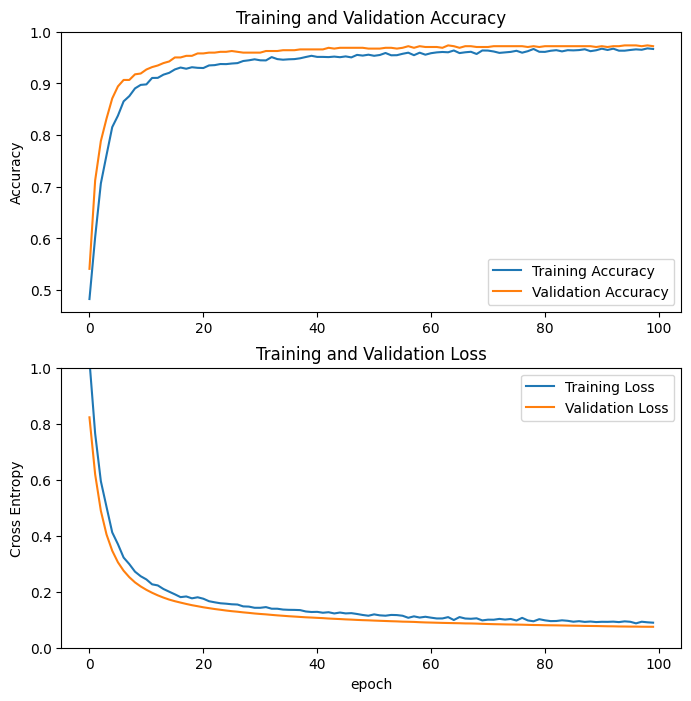

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [120]:
# freeze off base model

base_model.trainable = True

In [123]:
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  263


In [ ]:
fine_tune_at = 213

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [125]:
# model compile 2

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         callbacks=[cb_es,cb_cp],
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,)

Epoch 100/200
41/41 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9686
Epoch 100: saving model to ./runs/mnet_mix\100-0.97201.h5
41/41 [==============================] - 13s 206ms/step - loss: 0.0872 - accuracy: 0.9686 - val_loss: 0.0714 - val_accuracy: 0.9720
Epoch 101/200
40/41 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9695
Epoch 101: saving model to ./runs/mnet_mix\101-0.97201.h5
41/41 [==============================] - 8s 179ms/step - loss: 0.0798 - accuracy: 0.9697 - val_loss: 0.0687 - val_accuracy: 0.9720
Epoch 102/200
40/41 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9699
Epoch 102: saving model to ./runs/mnet_mix\102-0.97201.h5
41/41 [==============================] - 8s 177ms/step - loss: 0.0756 - accuracy: 0.9697 - val_loss: 0.0664 - val_accuracy: 0.9720
Epoch 103/200
40/41 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9699
Epoch 103: saving model to ./runs/mnet_mix\1

Epoch 129/200
40/41 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9971
Epoch 129: saving model to ./runs/mnet_mix\129-0.98600.h5
41/41 [==============================] - 8s 179ms/step - loss: 0.0125 - accuracy: 0.9971 - val_loss: 0.0498 - val_accuracy: 0.9860
Epoch 130/200
40/41 [============================>.] - ETA: 0s - loss: 0.0122 - accuracy: 0.9971
Epoch 130: saving model to ./runs/mnet_mix\130-0.98445.h5
41/41 [==============================] - 8s 179ms/step - loss: 0.0125 - accuracy: 0.9969 - val_loss: 0.0505 - val_accuracy: 0.9844
Epoch 131/200
40/41 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9963
Epoch 131: saving model to ./runs/mnet_mix\131-0.98445.h5
41/41 [==============================] - 8s 178ms/step - loss: 0.0127 - accuracy: 0.9963 - val_loss: 0.0509 - val_accuracy: 0.9844
Epoch 132/200
40/41 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9980
Epoch 132: saving model to ./runs/mnet_mix\13

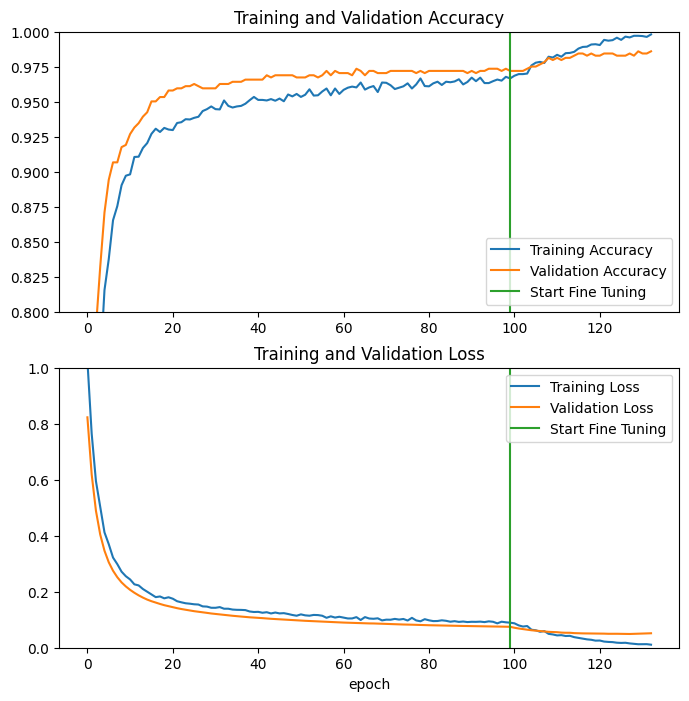

In [127]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [128]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 173ms/step - loss: 0.0789 - accuracy: 0.9768
Test accuracy : 0.9768160581588745


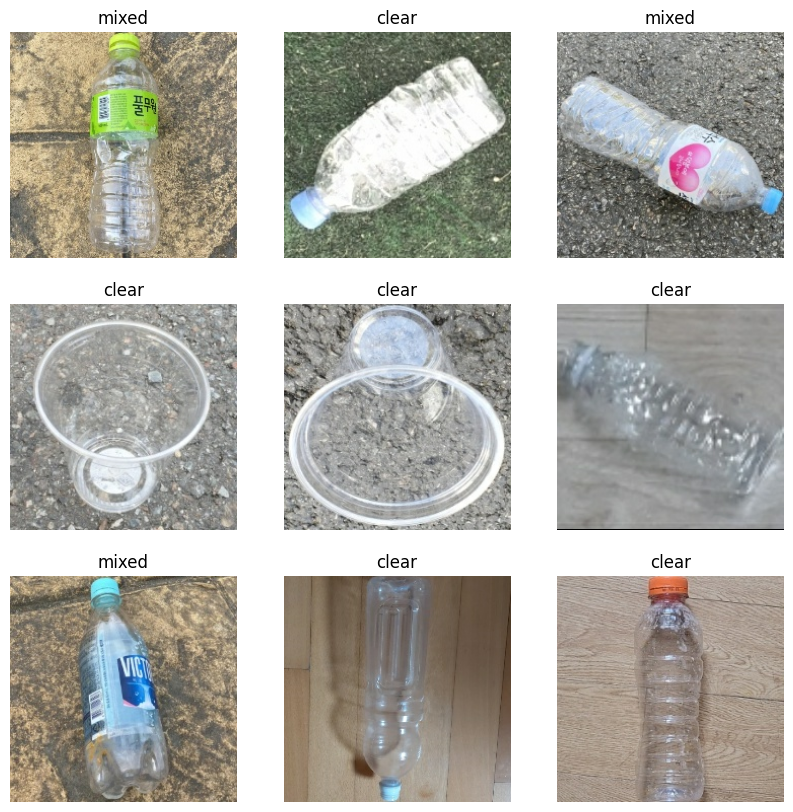

In [132]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.where(predictions < 0.5, 0, 1)


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i].argmax()])
    plt.axis("off")